# Insightly - The Naive Bayes Implementation

This notebook will go through the implementation of the Naive Bayes version of Insightly.

### Setup

Import required packages:

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

### Data Preprocessing

Let's start by looking at the data:

In [71]:
df = pd.read_csv('amazon_reviews.csv')
print(df.columns)
df.head()

Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound'],
      dtype='object')


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


The columns of interest are:
- overall: the actual review score (out of 5) that the product was given
- reviewText: the content of the review, which will be used for sentiment analysis
so we can drop the remaining columns

In [72]:
df = df[['overall', 'reviewText']]
df.head()

,overall,reviewText
0,4.0,No issues.
1,5.0,"Purchased this for my device, it worked as adv..."
2,4.0,it works as expected. I should have sprung for...
3,5.0,This think has worked out great.Had a diff. br...
4,5.0,"Bought it with Retail Packaging, arrived legit..."


Now we can take some steps to clean the data:

In [73]:
# remove missing values
df = df.dropna()

# remove duplicate reviews
df = df.drop_duplicates()

# remove nonexistent reviews
df = df[df['reviewText'].str.len() > 0]

The data is cleaned, and model development can begin.

### Model Development

The process of developing a Naive Bayes model is made rather simple by `scikit-learn`.

In [78]:
# Split features and target using the BALANCED dataset
X = df['reviewText']
y = df['overall']

# Split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())

Training set size: 3931
Test set size: 983

Class distribution in training set:
overall
1.0     195
2.0      64
3.0     114
4.0     421
5.0    3137
Name: count, dtype: int64


Build a pipeline with TF-IDF vectorization and Multinomial Naive Bayes:

In [80]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,        # Use top 5000 most important words
        stop_words='english',     # Remove common English words
        ngram_range=(1, 2),       # Use unigrams and bigrams
        min_df=2                  # Ignore terms that appear in less than 2 documents
    )),
    ('classifier', MultinomialNB(alpha=1.0))  # Laplace smoothing
])

# Train the model
model.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Model Evaluation

Evaluate the model's performance on the test set:

In [81]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7976

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        49
         2.0       0.00      0.00      0.00        16
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00       106
         5.0       0.80      1.00      0.89       784

    accuracy                           0.80       983
   macro avg       0.16      0.20      0.18       983
weighted avg       0.64      0.80      0.71       983



/Users/adarsh/.pyenv/versions/CS171/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/adarsh/.pyenv/versions/CS171/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/adarsh/.pyenv/versions/CS171/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

Visualize the confusion matrix:

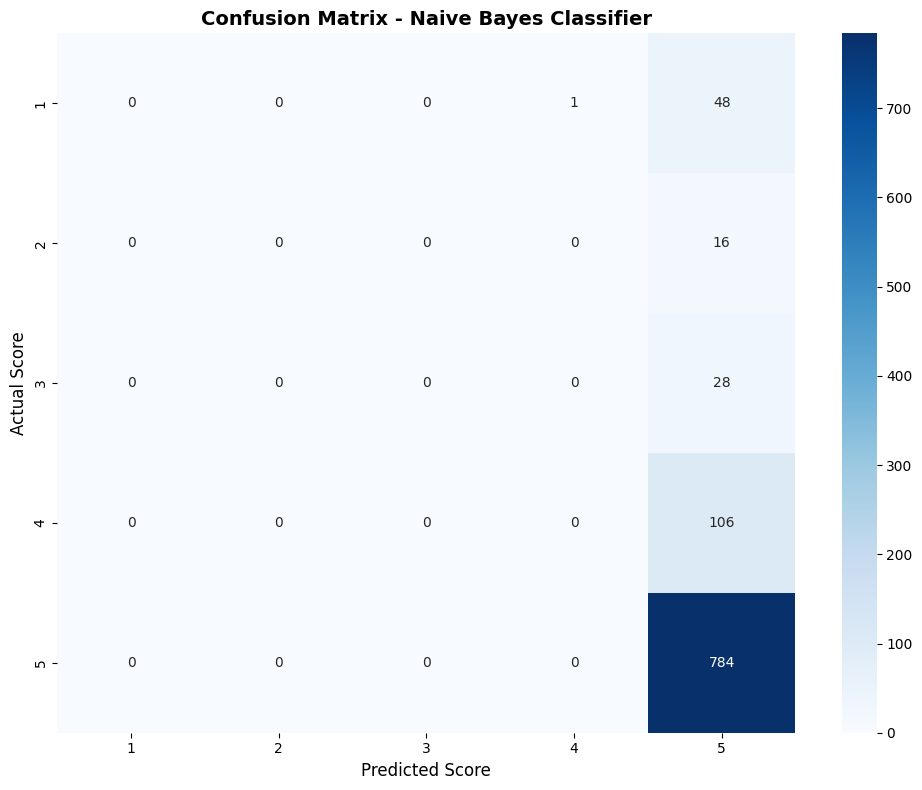

In [82]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], 
            yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix - Naive Bayes Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual Score', fontsize=12)
plt.xlabel('Predicted Score', fontsize=12)
plt.tight_layout()
plt.show()

As we can see, the model is extremely optimistic about every review. There are zero predicted scores below 4 and only one prediction of 4.

### Testing with Custom Reviews

Here's a helper function to help with predictions:

In [83]:
def predict_sentiment(review_text):
    prediction = model.predict([review_text])[0]
    probabilities = model.predict_proba([review_text])[0]
    
    print(f"Review: {review_text}")
    print(f"Predicted Score: {int(prediction)}\n")
    print("Probabilities for each score:")
    for score, prob in zip([1, 2, 3, 4, 5], probabilities):
        bar = '█' * int(prob * 50)
        print(f"  Score {int(score)}: {prob:.4f} {bar}")
    print("-" * 60)
    
    return prediction

Test the model with example reviews:

In [84]:
test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality, complete waste of money. Very disappointed.",
    "It's okay, nothing special but does the job.",
    "Good value for the price. Pretty satisfied with this purchase.",
    "Worst product I've ever bought. Do not recommend!"
]

for review in test_reviews:
    predict_sentiment(review)
    print()

Review: This product is absolutely amazing! Best purchase ever!
Predicted Score: 5

Probabilities for each score:
  Score 1: 0.0066 
  Score 2: 0.0010 
  Score 3: 0.0021 
  Score 4: 0.0143 
  Score 5: 0.9760 ████████████████████████████████████████████████
------------------------------------------------------------

Review: Terrible quality, complete waste of money. Very disappointed.
Predicted Score: 5

Probabilities for each score:
  Score 1: 0.1343 ██████
  Score 2: 0.0156 
  Score 3: 0.0400 ██
  Score 4: 0.1439 ███████
  Score 5: 0.6662 █████████████████████████████████
------------------------------------------------------------

Review: It's okay, nothing special but does the job.
Predicted Score: 5

Probabilities for each score:
  Score 1: 0.0111 
  Score 2: 0.0042 
  Score 3: 0.0111 
  Score 4: 0.0665 ███
  Score 5: 0.9071 █████████████████████████████████████████████
------------------------------------------------------------

Review: Good value for the price. Pretty satisfi

Sure enough, it's super optimistic about everything. We need to change the model definition a bit to make it less optimistic.

### Model Adjustments

Recall the distribution of the dataset:

In [85]:
X = df['reviewText']
y = df['overall']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())

Training set size: 3931
Test set size: 983

Class distribution in training set:
overall
1.0     195
2.0      64
3.0     114
4.0     421
5.0    3137
Name: count, dtype: int64


Nearly 80% of the entries are of rating 5, so this type of review is overrepresented in the data. We can change this by using class weights to give more importance to these underrepresented review ratings: 

In [86]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

sample_weights = np.array([class_weight_dict[label] for label in y_train])

Now let's re-train our model with the balanced weights:

In [87]:
model.fit(X_train, y_train, classifier__sample_weight=sample_weights)

,steps,"[('tfidf', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


Time to evaluate:

In [88]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5799

Classification Report:
              precision    recall  f1-score   support

         1.0       0.35      0.80      0.49        49
         2.0       0.05      0.12      0.07        16
         3.0       0.08      0.29      0.12        28
         4.0       0.17      0.33      0.23       106
         5.0       0.93      0.62      0.74       784

    accuracy                           0.58       983
   macro avg       0.32      0.43      0.33       983
weighted avg       0.78      0.58      0.65       983



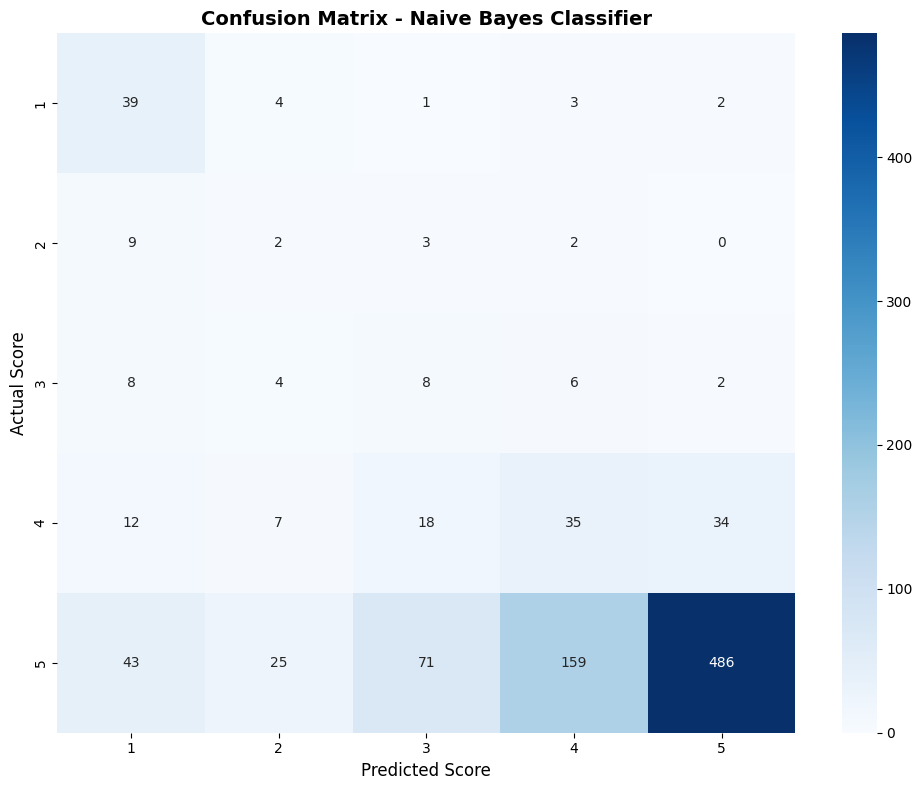

In [62]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5], 
            yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix - Naive Bayes Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual Score', fontsize=12)
plt.xlabel('Predicted Score', fontsize=12)
plt.tight_layout()
plt.show()

In [89]:
test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality, complete waste of money. Very disappointed.",
    "It's okay, nothing special but does the job.",
    "Good value for the price. Pretty satisfied with this purchase.",
    "Worst product I've ever bought. Do not recommend!"
]

for review in test_reviews:
    predict_sentiment(review)
    print()

Review: This product is absolutely amazing! Best purchase ever!
Predicted Score: 5

Probabilities for each score:
  Score 1: 0.2636 █████████████
  Score 2: 0.0615 ███
  Score 3: 0.0746 ███
  Score 4: 0.1429 ███████
  Score 5: 0.4574 ██████████████████████
------------------------------------------------------------

Review: Terrible quality, complete waste of money. Very disappointed.
Predicted Score: 1

Probabilities for each score:
  Score 1: 0.5563 ███████████████████████████
  Score 2: 0.0601 ███
  Score 3: 0.1962 █████████
  Score 4: 0.1052 █████
  Score 5: 0.0822 ████
------------------------------------------------------------

Review: It's okay, nothing special but does the job.
Predicted Score: 4

Probabilities for each score:
  Score 1: 0.0571 ██
  Score 2: 0.0746 ███
  Score 3: 0.2070 ██████████
  Score 4: 0.3534 █████████████████
  Score 5: 0.3079 ███████████████
------------------------------------------------------------

Review: Good value for the price. Pretty satisfie

Now we have intelligble results! The bad review was correctly marked as a 1, and the good reviews were given 4/5. This model appears to be a strong baseline which can be used to help develop the RNN.